In [1]:
# Import data from Excel sheet
import pandas as pd
import pandas as pd
df = pd.read_excel('ADNI combined.xlsx', sheet_name='sample')
#print(df)
sid = df['RID']
grp = df['Group at scan date (1=CN, 2=EMCI, 3=LMCI, 4=AD, 5=SMC)']
age = df['Age at scan']
sex = df['Sex (1=female)']
tiv = df['TIV_CAT12']
field = df['MRI_Field_Strength']
grpbin = (grp > 1) # 1=CN, ...
amybin = df['SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF']

In [2]:
# Scan for nifti file names
import glob
dataADNI3 = sorted(glob.glob('mwp1_MNI/ADNI3/*.nii.gz'))
dataFiles = dataADNI3
numfiles = len(dataFiles)
print('Found ', str(numfiles), ' nifti files')

Found  575  nifti files


In [3]:
# Match covariate information
import re
import numpy as np
from pandas import DataFrame
from keras.utils import to_categorical
debug = False
cov_idx = [-1] * numfiles # list; array: np.full((numfiles, 1), -1, dtype=int)
print('Matching covariates for loaded files ...')
for i,id in enumerate(sid):
  p = [j for j,x in enumerate(dataFiles) if re.search('_%04d_' % id, x)] # extract ID numbers from filename, translate to Excel row index
  if len(p)==0:
    if debug: print('Did not find %04d' % id) # did not find Excel sheet subject ID in loaded file selection
  else:
    if debug: print('Found %04d in %s: %s' % (id, p[0], dataFiles[p[0]]))
    cov_idx[p[0]] = i # store Excel index i for data file index p[0]
print('Checking for scans not found in Excel sheet: ', sum(x<0 for x in cov_idx))

labels = pd.DataFrame({'Group':grpbin}).iloc[cov_idx, :]
labels = to_categorical(np.asarray(labels)) # use grps to access original labels
grps = pd.DataFrame({'Group':grp, 'RID':sid}).iloc[cov_idx, :]
amy_status = pd.DataFrame({'amy_pos':amybin}).iloc[cov_idx, :]

Using TensorFlow backend.


Matching covariates for loaded files ...
Checking for scans not found in Excel sheet:  0


In [4]:
# Load original data from disk
import h5py
hf = h5py.File('orig_images_ADNI3_wb_mwp1_CAT12_MNI.hdf5', 'r')
hf.keys # read keys
images = np.array(hf.get('images'))
hf.close()
print(images.shape)

(575, 100, 100, 120, 1)


In [5]:
# determine amyloid status
amy_filter = np.equal(np.transpose(amy_status.to_numpy()), labels[:,1])
# filter index vector by amy status
test_idX = np.array(range(amy_filter.shape[1]))[np.squeeze(amy_filter)] 
grps = grps.iloc[test_idX, :]
images = images[test_idX, :]
labels = labels[test_idX, :]
print(images.shape)

(119, 100, 100, 120, 1)


In [6]:
# specify version of tensorflow
#%tensorflow_version 1.x  # <- use this for Google colab
import tensorflow as tf
# downgrade to specific version
#!pip install tensorflow-gpu==1.15
#import tensorflow as tf
print(tf.__version__)

# disable tensorflow deprecation warnings
import logging
logging.getLogger('tensorflow').disabled=True

1.15.4


In [7]:
# helper function to obtain performance result values
def get_values(conf_matrix):
    assert conf_matrix.shape==(2,2)
    tn, fp, fn, tp = conf_matrix.ravel()
    sen = tp / (tp+fn)
    spec = tn / (fp+tn)
    ppv = tp / (tp+fp)
    npv = tn / (tn+fn)
    f1 = 2 * ((ppv * sen) / (ppv + sen))
    bacc = (spec + sen) / 2
    return bacc, sen, spec, ppv, npv, f1

validating model model_rawdat_checkpoints/rawmodel_wb_cv1.best.hdf5


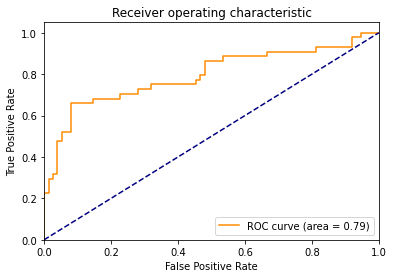

AUC for MCI vs. CN = 0.764
AUC for AD vs. CN = 0.841
Acc for MCI vs. CN = 80.4
Acc for AD vs. CN = 83.7
confusion matrix
[[65 10]
 [10 17]
 [ 5 12]]
validating model model_rawdat_checkpoints/rawmodel_wb_cv2.best.hdf5


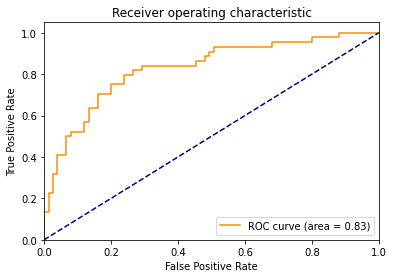

AUC for MCI vs. CN = 0.775
AUC for AD vs. CN = 0.915
Acc for MCI vs. CN = 78.4
Acc for AD vs. CN = 82.6
confusion matrix
[[63 12]
 [10 17]
 [ 4 13]]
validating model model_rawdat_checkpoints/rawmodel_wb_cv3.best.hdf5


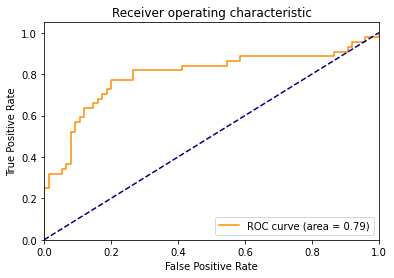

AUC for MCI vs. CN = 0.740
AUC for AD vs. CN = 0.881
Acc for MCI vs. CN = 77.5
Acc for AD vs. CN = 81.5
confusion matrix
[[61 14]
 [ 9 18]
 [ 3 14]]
validating model model_rawdat_checkpoints/rawmodel_wb_cv4.best.hdf5


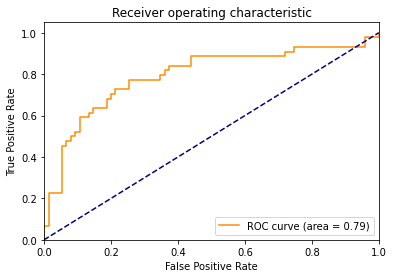

AUC for MCI vs. CN = 0.735
AUC for AD vs. CN = 0.885
Acc for MCI vs. CN = 72.5
Acc for AD vs. CN = 82.6
confusion matrix
[[61 14]
 [14 13]
 [ 2 15]]
validating model model_rawdat_checkpoints/rawmodel_wb_cv5.best.hdf5


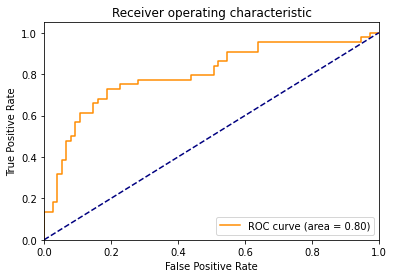

AUC for MCI vs. CN = 0.755
AUC for AD vs. CN = 0.867
Acc for MCI vs. CN = 55.9
Acc for AD vs. CN = 54.3
confusion matrix
[[34 41]
 [ 4 23]
 [ 1 16]]
validating model model_rawdat_checkpoints/rawmodel_wb_cv6.best.hdf5


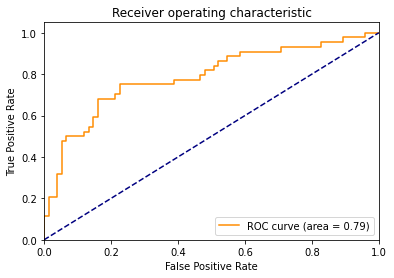

AUC for MCI vs. CN = 0.737
AUC for AD vs. CN = 0.864
Acc for MCI vs. CN = 74.5
Acc for AD vs. CN = 79.3
confusion matrix
[[58 17]
 [ 9 18]
 [ 2 15]]
validating model model_rawdat_checkpoints/rawmodel_wb_cv7.best.hdf5


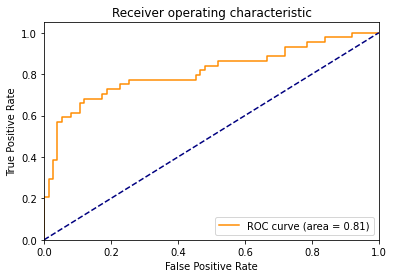

AUC for MCI vs. CN = 0.772
AUC for AD vs. CN = 0.870
Acc for MCI vs. CN = 82.4
Acc for AD vs. CN = 85.9
confusion matrix
[[67  8]
 [10 17]
 [ 5 12]]
validating model model_rawdat_checkpoints/rawmodel_wb_cv8.best.hdf5


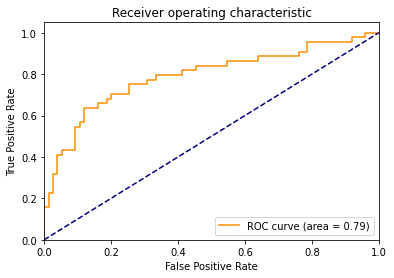

AUC for MCI vs. CN = 0.721
AUC for AD vs. CN = 0.898
Acc for MCI vs. CN = 75.5
Acc for AD vs. CN = 78.3
confusion matrix
[[59 16]
 [ 9 18]
 [ 4 13]]
validating model model_rawdat_checkpoints/rawmodel_wb_cv9.best.hdf5


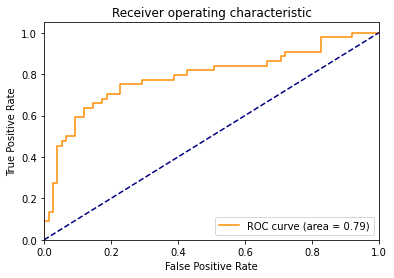

AUC for MCI vs. CN = 0.711
AUC for AD vs. CN = 0.912
Acc for MCI vs. CN = 76.5
Acc for AD vs. CN = 82.6
confusion matrix
[[62 13]
 [11 16]
 [ 3 14]]
validating model model_rawdat_checkpoints/rawmodel_wb_cv10.best.hdf5


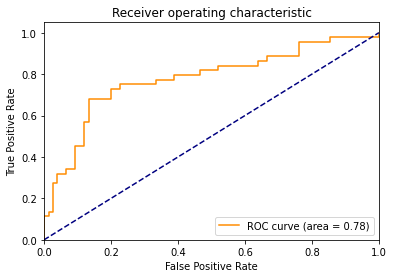

AUC for MCI vs. CN = 0.737
AUC for AD vs. CN = 0.840
Acc for MCI vs. CN = 53.9
Acc for AD vs. CN = 54.3
confusion matrix
[[34 41]
 [ 6 21]
 [ 1 16]]


In [8]:
# validation
import numpy as np
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
%matplotlib inline
import keras
from keras import models
import tensorflow as tf
from sklearn.metrics import confusion_matrix

acc_AD, acc_MCI, auc_AD, auc_MCI = [], [], [], []
bacc_AD, bacc_MCI = [], []
sen_AD, sen_MCI, spec_AD, spec_MCI = [], [], [], []
ppv_AD, ppv_MCI, npv_AD, npv_MCI = [], [], [], []
f1_AD, f1_MCI = [], []

num_kfold = 10 # number of cross-validation loops equal to number of models
batch_size = 20

for k in range(num_kfold):
    print('validating model model_rawdat_checkpoints/rawmodel_wb_cv%d.best.hdf5' % (k+1))
    mymodel = models.load_model('model_rawdat_checkpoints/rawmodel_wb_cv%d.best.hdf5' % (k+1))
    
    # calculate area under the curve
    # AUC as optimization function during training: https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
    pred = mymodel.predict(images, batch_size=batch_size)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    acc = dict()
    for i in range(2): # classes dummy vector: 0 - CN, 1 - MCI/AD
        fpr[i], tpr[i], _ = roc_curve(labels[:, i], pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr[1], tpr[1], color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # redo AUC for binary comparison: AD vs. HC and MCI vs. HC
    for i in [3,4]:
      grpi = np.equal(grps.Group.to_numpy(dtype=np.int), np.ones((grps.shape[0],), dtype=np.int)*i)
      grp1 = np.equal(grps.Group.to_numpy(dtype=np.int), np.ones((grps.shape[0],), dtype=np.int))
      grpidx = np.logical_or(grpi, grp1)
      fpr[i], tpr[i], _ = roc_curve(labels[grpidx, 1], pred[grpidx, 1])
      roc_auc[i] = auc(fpr[i], tpr[i])
      acc[i] = np.mean((labels[grpidx, 1] == np.round(pred[grpidx, 1])).astype(int))*100

    print('AUC for MCI vs. CN = %0.3f' % roc_auc[3])
    print('AUC for AD vs. CN = %0.3f' % roc_auc[4])
    print('Acc for MCI vs. CN = %0.1f' % acc[3])
    print('Acc for AD vs. CN = %0.1f' % acc[4])
    auc_AD.append(roc_auc[4])
    auc_MCI.append(roc_auc[3])
    acc_AD.append(acc[4])
    acc_MCI.append(acc[3])
    
    print('confusion matrix')
    confmat = confusion_matrix(grps.Group, np.round(pred[:, 1]))
    bacc, sen, spec, ppv, npv, f1 = get_values(confmat[(1,2),0:2]) # MCI
    bacc_MCI.append(bacc); sen_MCI.append(sen); spec_MCI.append(spec); ppv_MCI.append(ppv); npv_MCI.append(npv); f1_MCI.append(f1)
    bacc, sen, spec, ppv, npv, f1 = get_values(confmat[(1,3),0:2]) # AD
    bacc_AD.append(bacc); sen_AD.append(sen); spec_AD.append(spec); ppv_AD.append(ppv); npv_AD.append(npv); f1_AD.append(f1)
    print(confmat[1:4,0:2])

In [9]:
# print model performance summary
from statistics import mean,stdev

print('Mean AUC for MCI vs. CN = %0.3f +/- %0.3f' % (mean(auc_MCI), stdev(auc_MCI)))
print('Mean AUC for AD vs. CN = %0.3f +/- %0.3f' % (mean(auc_AD), stdev(auc_AD)))
print('Mean Acc for MCI vs. CN = %0.3f +/- %0.3f' % (mean(acc_MCI), stdev(acc_MCI)))
print('Mean Acc for AD vs. CN = %0.3f +/- %0.3f' % (mean(acc_AD), stdev(acc_AD)))
print('Mean Bacc for MCI vs. CN = %0.3f +/- %0.3f' % (mean(bacc_MCI), stdev(bacc_MCI)))
print('Mean Bacc for AD vs. CN = %0.3f +/- %0.3f' % (mean(bacc_AD), stdev(bacc_AD)))
print('Mean Sen for MCI vs. CN = %0.3f +/- %0.3f' % (mean(sen_MCI), stdev(sen_MCI)))
print('Mean Sen for AD vs. CN = %0.3f +/- %0.3f' % (mean(sen_AD), stdev(sen_AD)))
print('Mean Spec for MCI vs. CN = %0.3f +/- %0.3f' % (mean(spec_MCI), stdev(spec_MCI)))
print('Mean Spec for AD vs. CN = %0.3f +/- %0.3f' % (mean(spec_AD), stdev(spec_AD)))
print('Mean PPV for MCI vs. CN = %0.3f +/- %0.3f' % (mean(ppv_MCI), stdev(ppv_MCI)))
print('Mean PPV for AD vs. CN = %0.3f +/- %0.3f' % (mean(ppv_AD), stdev(ppv_AD)))
print('Mean NPV for MCI vs. CN = %0.3f +/- %0.3f' % (mean(npv_MCI), stdev(npv_MCI)))
print('Mean NPV for AD vs. CN = %0.3f +/- %0.3f' % (mean(npv_AD), stdev(npv_AD)))
print('Mean F1 for MCI vs. CN = %0.3f +/- %0.3f' % (mean(f1_MCI), stdev(f1_MCI)))
print('Mean F1 for AD vs. CN = %0.3f +/- %0.3f' % (mean(f1_AD), stdev(f1_AD)))

Mean AUC for MCI vs. CN = 0.745 +/- 0.021
Mean AUC for AD vs. CN = 0.877 +/- 0.026
Mean Acc for MCI vs. CN = 72.745 +/- 9.824
Mean Acc for AD vs. CN = 76.522 +/- 11.876
Mean Bacc for MCI vs. CN = 0.706 +/- 0.049
Mean Bacc for AD vs. CN = 0.788 +/- 0.052
Mean Sen for MCI vs. CN = 0.659 +/- 0.100
Mean Sen for AD vs. CN = 0.824 +/- 0.088
Mean Spec for MCI vs. CN = 0.752 +/- 0.161
Mean Spec for AD vs. CN = 0.752 +/- 0.161
Mean PPV for MCI vs. CN = 0.523 +/- 0.108
Mean PPV for AD vs. CN = 0.468 +/- 0.107
Mean NPV for MCI vs. CN = 0.861 +/- 0.021
Mean NPV for AD vs. CN = 0.952 +/- 0.017
Mean F1 for MCI vs. CN = 0.570 +/- 0.063
Mean F1 for AD vs. CN = 0.584 +/- 0.083


In [10]:
results = pd.DataFrame({'AUC_MCI':auc_MCI, 'Acc_MCI':acc_MCI, 'Bacc_MCI':bacc_MCI, 'f1_MCI':f1_MCI,
                        'sen_MCI':sen_MCI, 'spec_MCI':spec_MCI, 'ppv_MCI':ppv_MCI, 'npv_MCI':npv_MCI,
                        'AUC_AD':auc_AD, 'Acc_AD':acc_AD, 'Bacc_AD':bacc_AD, 'f1_AD':f1_AD,
                        'sen_AD':sen_AD, 'spec_AD':spec_AD, 'ppv_AD':ppv_AD, 'npv_AD':npv_AD})
print(results)
results.to_csv('results_xval_rawdat_ADNI3_amy_checkpoints.csv')

    AUC_MCI    Acc_MCI  Bacc_MCI    f1_MCI   sen_MCI  spec_MCI   ppv_MCI  \
0  0.764444  80.392157  0.748148  0.629630  0.629630  0.866667  0.629630   
1  0.774815  78.431373  0.734815  0.607143  0.629630  0.840000  0.586207   
2  0.739753  77.450980  0.740000  0.610169  0.666667  0.813333  0.562500   
3  0.735309  72.549020  0.647407  0.481481  0.481481  0.813333  0.481481   
4  0.754568  55.882353  0.652593  0.505495  0.851852  0.453333  0.359375   
5  0.736790  74.509804  0.720000  0.580645  0.666667  0.773333  0.514286   
6  0.772346  82.352941  0.761481  0.653846  0.629630  0.893333  0.680000   
7  0.721481  75.490196  0.726667  0.590164  0.666667  0.786667  0.529412   
8  0.710617  76.470588  0.709630  0.571429  0.592593  0.826667  0.551724   
9  0.736790  53.921569  0.615556  0.471910  0.777778  0.453333  0.338710   

    npv_MCI    AUC_AD     Acc_AD   Bacc_AD     f1_AD    sen_AD   spec_AD  \
0  0.866667  0.840784  83.695652  0.786275  0.615385  0.705882  0.866667   
1  0.863014